## Step 1 (Preparation & Utility): 

In [145]:
""" Import Libraries """

import numpy as np
import pandas as pd
import scipy as sp
import scipy.optimize
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils.random import check_random_state
import os
from scipy import interpolate


plt.style.use('ggplot') # choose plotting style

os.getcwd()

'C:\\Users\\moche\\Documents\\working_programs'

In [146]:
" Data Importing "

# Extract dataframe from .csv and turn to numpy array
df = pd.read_csv('Lip_space_time-17-Nov-2021.csv') 
data = df.to_numpy()

# Remove NaN columns 
adj_data = np.delete(data,[7,12,13,14],1) # Removed PI45P2, Carmil, ArpB & PI4P columns 

# Extract column values separately 
gDistance = adj_data[:,0]
time = adj_data[:,1]
Curvature = adj_data[:,2]
PIP3 = adj_data[:,3]
Actin= adj_data[:,4]
NAP = adj_data[:,5]
PI34P2 = adj_data[:,6]
PTEN = adj_data[:,7]
Myo1B = adj_data[:,8]
Myo1E = adj_data[:,9]
Coronin = adj_data[:,10]

print(df)

            x   t  curvature       PIP3   LifeAct       NAP    PI34P2  PI45P2  \
0    4.000000 -60   0.032085   1.259733  1.064708  1.113695  1.125664     NaN   
1    4.000000 -57   0.033874   1.252147  0.965258  1.060444  1.077171     NaN   
2    4.000000 -54   0.033550   1.404829  0.869329  1.020091  1.003469     NaN   
3    4.000000 -51   0.034951   1.334462  0.892470  1.038189  1.061488     NaN   
4    4.000000 -48   0.028391   1.124881  0.879124  1.046749  0.977287     NaN   
..        ...  ..        ...        ...       ...       ...       ...     ...   
815 -2.149249 -15  -0.210964  13.760881  6.620512  0.720635  2.163126     NaN   
816 -2.172579 -12  -0.188980  13.273090  6.449913  0.822756  1.962913     NaN   
817 -2.256668  -9  -0.204499  14.720457  6.725740  0.826510  1.762699     NaN   
818 -2.396042  -6  -0.287903  16.591508  6.945560  0.795949  1.562486     NaN   
819 -2.613560  -3  -0.390188  17.313876  6.589804  0.793550  1.362272     NaN   

         PTEN     Myo1B    

## Step 2 (Numerical & Abstract Processing):

In [147]:
" Data Processing "

def dc_dt(c_arr, t_int, mov_len):
    
    """
    - Function to calculate the corresponding rate of change of flux w.r.t time.
    - Under assumption that input c_arr follows time scheme given in df of input data.
    - First 19 values are calculated with constant time interval 3s, 20th automatically
      set to zero. 
    
    Inputs: c_arr (1D Array)    - Input array of concentration values for series of cup closures 
            t_int (int)         - Time interval at which measurements were taken for concentration values
            mov_len (int)       - Number of time measurements (elements) per movie. This value minus 1 is the number of 
                                  dc_dt values that can be calculated.
   
    Outputs: dc_arr(array(1D)) - Output array of dc/dt values for all concentration points sans 20*nth values
    
    """
    
    num_of_elements = len(c_arr) # number of total elements in input array
    num_of_movies = num_of_elements/mov_len # self explanatory, num of elements / number of elements per movie = movie num
    zero_ind_arr = np.subtract(np.multiply(np.arange(1, num_of_movies+1), mov_len), 1) #[mov_len-1, 2*mov_len-1,...]
    
    dc_arr = np.empty([num_of_elements,1]) # initialise array to hold dc/dt values
    
    for value in range(num_of_elements-1): # for each element in the concentration array...
        
        dc_arr[value]= (c_arr[value+1]-c_arr[value])/t_int # ... find difference with successive (by time) conc. value in movie 
    
    # eliminate dc/dt values calculated for final concentration value in each movie as these are calculated across movies
    for index in range(len(zero_ind_arr)):
        
        dc_arr[int(zero_ind_arr[index])] = 0 # set to zero (arbitrary)
    
    return dc_arr


In [148]:
" Data Processing "

def time_isolator(mat, ctime1, ctime2, col_ind):
    
    """
    - Takes a stack array of data with time as a column. 
    - Times are expected to be negative. These represent times until closure.
    - Deletes any rows which are before 'ctime1' or after 'ctime2'
    
    Inputs: mat (N x M Array) - Matrix of M features with N entries for each column
            ctime1 (int)      - Positive time until closure, upper limit. Rows with larger times than this will be deleted
            ctime2 (int)      - Positive time until closure, lower limit. Rows with smaller times than this will be deleted
            col_ind (int)     - Column index of time column.
    
    Outputs: isol_arr (L X M array) - Matrix of M features with L <= N entries for each column.
    
    """
    isol_arr = mat
    
    isol_arr = np.delete(isol_arr, np.where((isol_arr[:,col_ind]<-ctime1)), axis=0) # remove rows with times before ctime1
    isol_arr = np.delete(isol_arr, np.where((isol_arr[:,col_ind]>-ctime2)), axis=0) # remove rows with times after ctime2
    
    return isol_arr


In [149]:
" Data Processing "

def null_net(c_mat, val_ind, tol):
    
    """
    - Interpolates the nullcline points based on a tolerance specified
    
    Inputs: 'c_mat' (N x M Array)   - 'Coordinate' matrix containing the information pertaining to the corresponding row indices
                                    in val_mat. This is the information that will be returned.
            'v_ind' (int)         - Index to the column for whose variable it represents will be interpolated for 0 value
            'tol' (float)           - Value between 0 and 1, representing the proportion of ordered data that will be approximated
                                    to be a representative sample of nullclines. 
    
    Outputs: dXi_null (List)     -  nullcline points selected as per the tolerance
    
    """
    
    dXisorted = c_mat[abs(c_mat[:,val_ind]).argsort()] # sort data array by absolute dXdt values
    
    dXi_null = dXisorted[0:int(tol*len(dXisorted)),:] # select tol % of ordered low -> high data points
        
    return dXi_null
  

In [150]:
def null_id(c_mat, v_ind, tol, metric):
    
    """
    - Approximates nullcline points within a % of the range
    
    Inputs: 'c_mat' (N x M Array) - Coordinate matrix containing complete information associated with each point, with
                                    N data points and M features
            'v_ind' (int)         - Index to the column for whose variable it represents will be interpolated for 0 value
            'tol' (int)           - Value between 0 and 1 representing the % of the range of the +ve/-ve array
    
    """
    
    # separate +ve & -ve dX(i)/dt values
    pos_arr = c_mat[c_mat[:, v_ind] > 0] 
    neg_arr = c_mat[c_mat[:, v_ind] < 0] 
    
    if (metric == 'range'):
        
        # calculate range of both arrays
        pos_id = np.ptp(pos_arr[:, v_ind])
        neg_id = np.ptp(neg_arr[:, v_ind])
    
    elif (metric == 'variance'):
        
        # calculate variance of both arrays
        pos_id = 1/np.std(pos_arr[:, v_ind])
        neg_id = 1/np.std(neg_arr[:, v_ind])
        
    elif (metric == 'mean'):
        
        # calculate mean of both arrays
        pos_id = np.mean(pos_arr[:, v_ind])
        neg_id = np.mean(neg_arr[:, v_ind])
        
    else:
        
        return ("Error: Invalid metric parameter - Choose from 'range', 'variance' or 'mean'.")
    
    
    # select points within tolerance above and below 0 axis/plane
    pos_null_arr = pos_arr[abs(pos_arr[:, v_ind]) < (pos_id*tol)] 
    neg_null_arr = neg_arr[abs(neg_arr[:, v_ind]) < (neg_id*tol)] 
    
    return np.vstack((pos_null_arr, neg_null_arr))


## Step 3 (Investigations):

### Set-up

In [171]:
X = PIP3 # activator choice
Y = NAP # inhibitor choice

dXdt = dc_dt(X,3,20) 
dYdt = dc_dt(Y,3,20)

### Isolate nullclines for dc/dt = 0

In [361]:
data_stack = np.column_stack((X,Y,dXdt,dYdt,time))
data_stack = time_isolator(data_stack, 60, 48, 4) # restrict data set between upper and lower time limits
data_stack = np.delete(data_stack, np.where((data_stack[:,2] == 0.0) | (data_stack[:,3] == 0.0)), axis=0) # remove 0 entries

stack_as_df = pd.DataFrame(data_stack, columns = ['X','Y','dX/dt', 'dY/dt','time'])

tolerance = 0.005
x_null_arr = null_id(data_stack, 2, tolerance, "range")
y_null_arr = null_id(data_stack, 3, tolerance, "range")


Text(0.5, 1.0, 'Y nullcline, tol=0.5%, 8 data points')

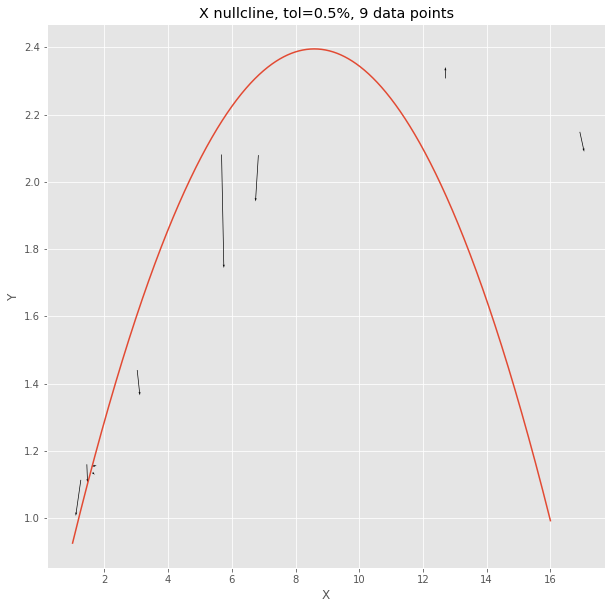

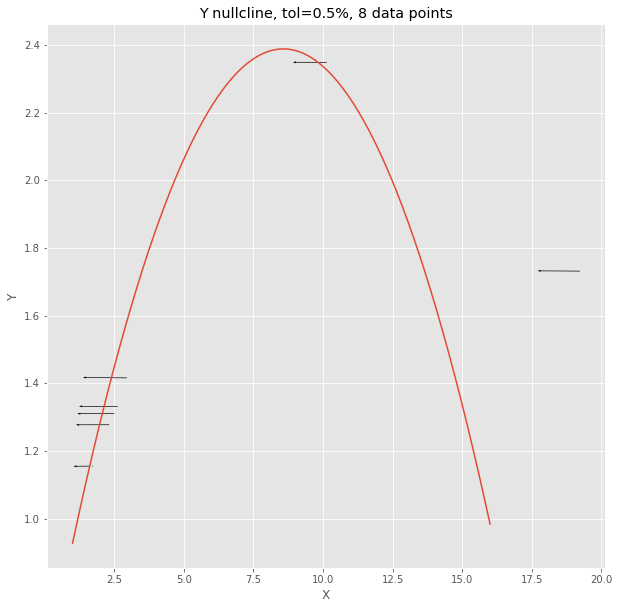

In [362]:
fig_x_null, ax_x_null = plt.subplots(figsize=(10,10))
fig_y_null, ax_y_null = plt.subplots(figsize=(10,10))

ax_x_null.plot(x_range, dX_curve_y)

ax_x_null.quiver(x_null_arr[:,0], x_null_arr[:,1], x_null_arr[:,2], x_null_arr[:,3], width=0.0012)
ax_x_null.set_xlabel('X')
ax_x_null.set_ylabel('Y')
#ax_x_null.scatter(x_null_arr[:,0], x_null_arr[:,1], marker='x', color='black')
ax_x_null.set_title("X nullcline, " + "tol=" + str(tolerance*100) +"%" + ", " + str(len(x_null_arr)) + " data points")

ax_y_null.plot(x_range,dY_curve_y)

ax_y_null.quiver(y_null_arr[:,0], y_null_arr[:,1], y_null_arr[:,2], y_null_arr[:,3], width=0.0012)
ax_y_null.set_xlabel('X')
ax_y_null.set_ylabel('Y')
#ax_y_null.scatter(y_null_arr[:,0], y_null_arr[:,1], marker='x', color='black')
ax_y_null.set_title("Y nullcline, " + "tol=" + str(tolerance*100) +"%" + ", " + str(len(y_null_arr)) + " data points")


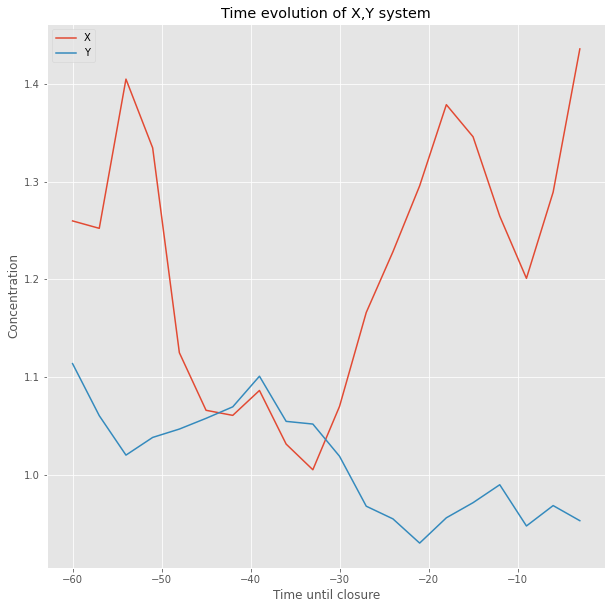

In [324]:
phase = np.column_stack((X,Y,dXdt,dYdt,time))
phase = phase[0:20,:]

plt.title("Time evolution of X,Y system")
plt.plot(phase[:,4], phase[:,0], label='X')
plt.plot(phase[:,4], phase[:,1], label='Y')
plt.xlabel("Time until closure")
plt.ylabel("Concentration")
plt.rcParams["figure.figsize"] = 10,10
plt.legend()

### Speculative Model Fitting

In [330]:
x_range = np.linspace(1,16,1000)

In [331]:
# find polynomial model for dXdt curve

xnull_x_vals = x_null_arr[:,0]
xnull_y_vals = x_null_arr[:,1]

x_p = np.polyfit(xnull_x_vals, xnull_y_vals, 2)
x_z = np.poly1d(x_p)

dX_curve_y = x_z(x_range)

print(x_p)

[-0.02553168  0.43848203  0.51278944]


In [332]:
# find polynomial model for dYdt curve

ynull_x_vals = y_null_arr[:,0]
ynull_y_vals = y_null_arr[:,1]

y_p = np.polyfit(ynull_x_vals, ynull_y_vals, 2)
y_z = np.poly1d(y_p)

dY_curve_y = y_z(x_range)

print(y_p)

[-0.02545972  0.43656365  0.51692473]


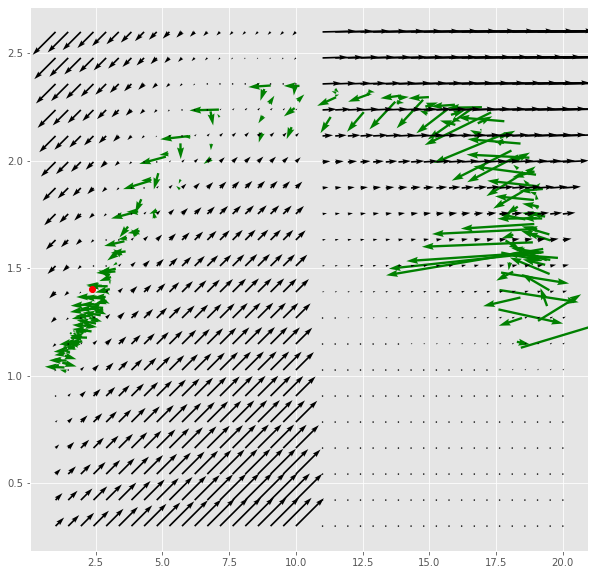

In [365]:
x,y = np.meshgrid(np.linspace(1,10,20),np.linspace(0.3,2.6,20))
xx,yy = np.meshgrid(np.linspace(11,20,20),np.linspace(0.3,2.6,20))

uu = xx**yy
vv = xx+yy/5

u = x_p[0]*x**2+x_p[1]*x+x_p[2]-y
v = y_p[0]*x**2+y_p[1]*x+y_p[2]-y

plt.quiver(data_stack[:,0],data_stack[:,1], data_stack[:,2], data_stack[:,3], color = 'g' )
plt.plot(x_range[idx], dY_curve_y[idx], 'ro')
plt.quiver(x,y,u,v)
plt.quiver(xx,yy,uu,vv)
plt.show()

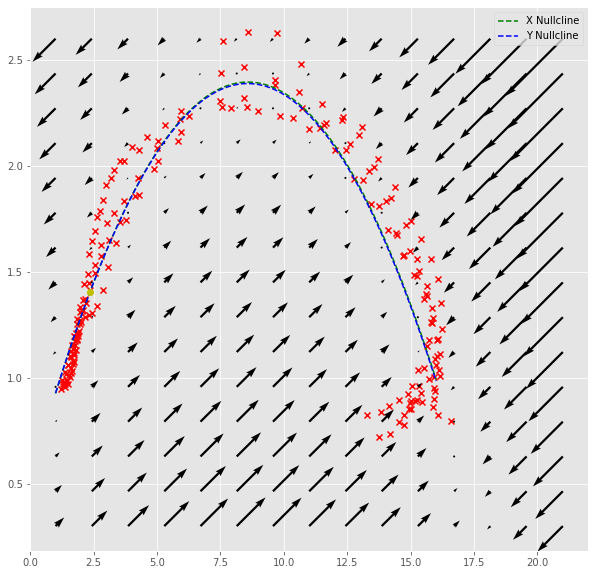

In [342]:
x,y = np.meshgrid(np.linspace(1,21,15),np.linspace(0.3,2.6,15))

u = x_p[0]*x**2+x_p[1]*x+x_p[2]-y
v = y_p[0]*x**2+y_p[1]*x+y_p[2]-y

plt.scatter(data_stack[:,0],data_stack[:,1], marker = 'x', color = 'r' )
plt.plot(x_range, dX_curve_y, label="X Nullcline", color = 'green', linestyle='--')
plt.plot(x_range, dY_curve_y, label="Y Nullcline", color = 'blue', linestyle= '--')
plt.plot(x_range[idx], dY_curve_y[idx], 'yo')
plt.legend()
plt.quiver(x,y,u,v)
plt.show()

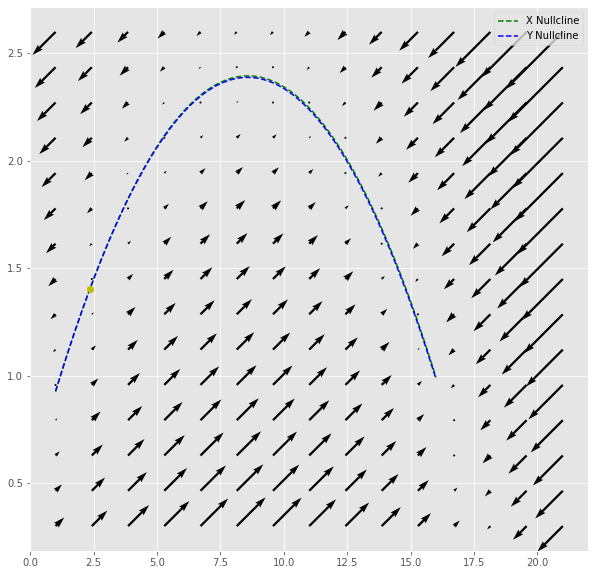

In [343]:
# x,y = np.meshgrid(np.linspace(1,21,15),np.linspace(1,2.4,15))

u = x_p[0]*x**2+x_p[1]*x+x_p[2]-y
v = y_p[0]*x**2+y_p[1]*x+y_p[2]-y

plt.plot(x_range, dX_curve_y, label="X Nullcline", color = 'green', linestyle='--')
plt.plot(x_range, dY_curve_y, label="Y Nullcline", color = 'blue', linestyle= '--')
plt.plot(x_range[idx], dY_curve_y[idx], 'yo')
plt.legend()
plt.quiver(x,y,u,v)
plt.show()

In [339]:
# Find fixed points of system

idx = np.argwhere(np.diff(np.sign(dY_curve_y - dX_curve_y))).flatten()

print('-----------------')

for i in range(len(idx)):
    
    print("Fixed point " + str(i) + " is: (%s, %s)" % (x_range[idx[i]], dY_curve_y[idx[i]]))
    
print('-----------------')    

-----------------
Fixed point 0 is: (2.3513513513513513, 1.4026761948177822)
-----------------


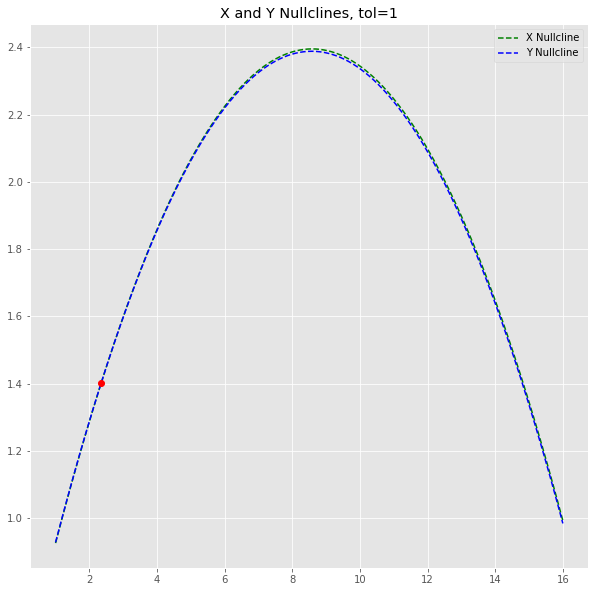

In [344]:
fig_quad, ax_quad = plt.subplots(figsize=(10,10))



ax_quad.set_title("X and Y Nullclines, tol=" + str(tolerance),)
ax_quad.plot(x_range, dX_curve_y, label="X Nullcline", color = 'green', linestyle='--')
ax_quad.plot(x_range, dY_curve_y, label="Y Nullcline", color = 'blue', linestyle= '--')
plt.plot(x_range[idx], dY_curve_y[idx], 'ro')
ax_quad.legend()


### Univariate Spline Nullcline Interpolation

In [482]:
" Data Processing "

def interpMovieNullclines(movie_data, Z_col, spat_cols, t_int, mov_len):
    
    Z_vals = movie_data[:, Z_col] # corresponding chemical X values
    dZdt_vals = dc_dt(Z_vals, t_int, mov_len) # find dX/dt
    
                                            # remove the final time value...
    dZdt_vals[mov_len-1] = dZdt_vals[mov_len-2] # ... as this corresponds to a null dXdt value
    
    X = movie_data[:,spat_cols]
    col_num = X.shape[1]
    
    u = np.cumsum(np.r_[[0], np.linalg.norm(np.diff(X, axis=0), axis=1)]) # chord length parameterization
    sz = interpolate.InterpolatedUnivariateSpline(u, dZdt_vals)  # z(u) spline
    
    a = sz.roots() # root values returned in terms of parametrization 'u'
    
    nullcline_array = np.empty((len(a), col_num), dtype=float)
    
    
    for i in range(col_num): # iterate through phase coordinate columns
        
        weight = np.linspace(1, 0.1, len(X[:,i]))
        sX = interpolate.UnivariateSpline(u, X[:,i], k=1, w=weight) # univariate spline for selected column
        
        null_X = sX(a) # interpolated piecewise function evaluated at root Z values in terms of u 
            
        nullcline_array[:,i] = null_X    
        
    return nullcline_array



In [483]:
" Data Processing "

def fullSeriesProcessing(series_data, Z_col, spat_cols, t_int, mov_len, num_of_movies):
    
    indices = np.arange(0,num_of_movies+1,1)
    indices = indices * mov_len
    
    full_nullclines = np.empty((1,len(spat_cols)), dtype=float)
    
    for i in range(len(indices)-1):
        
        movie = series_data[indices[i]:indices[i+1],:]
        
        b = interpMovieNullclines(movie, Z_col, spat_cols, t_int, mov_len)
        
        full_nullclines = np.vstack((full_nullclines, b))
    
    full_nullclines = np.delete(full_nullclines, 0, 0)#
    
    return(full_nullclines)


Text(0.5, 1.0, 'Interpolated Nullclines for 1st Regime, k=1, 70 data points')

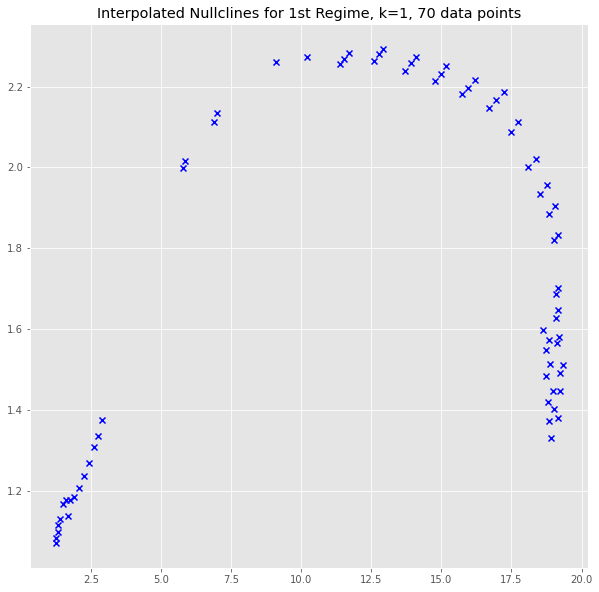

In [484]:
c = fullSeriesProcessing(adj_data, 3, np.array([1, 3,5]), 3,20, 41)
d = fullSeriesProcessing(adj_data, 5, np.array([1, 3,5]), 3,20, 41)

e = time_isolator(c, 60,48, 0)
f = time_isolator(d, 60,48, 0)

plt.scatter(e[:,1],e[:,2], color = 'blue', marker='x', label = '(PIP3) X Nullcline')
#plt.scatter(f[:,1],f[:,2], label = '(NAP) Y Nullcline')
plt.title("Interpolated Nullclines for 1st Regime, k=1" + ", " + str(len(e)) + " data points")
#plt.legend()


### Symbolic Regression Algorithm

In [116]:


x_train = x_null_arr[:,0].reshape(-1,1)
y_train = x_null_arr[:,1]


In [117]:
est_gp = SymbolicRegressor(population_size=5000, #the number of programs in each generation
                           generations=20, stopping_criteria=0.01, #The required metric value required in order to stop evolution early.
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05,
                           p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           metric='mse',
                           parsimony_coefficient=0.01, random_state=0)

est_gp.fit(x_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81      1.16865e+21       31        0.0351572        0.0665723      2.03m
   1    20.59      4.18775e+08        7        0.0316466         0.162589      1.19m
   2     8.68      4.58091e+14        7        0.0200651         0.137128     51.42s
   3     5.72      5.51802e+08        7        0.0235389         0.109337     53.31s
   4     3.55      8.89791e+06        7        0.0304905        0.0537243     47.16s
   5     3.45      2.23327e+13        3        0.0432632         0.223065     44.56s
   6     3.37      2.39834e+08        3        0.0432632         0.223065     42.93s
   7     3.40           266161        3        0.0432632         0.223065     41.22s
   8     3.43       6.0796e+09        3        0.0432632         0.223065  

SymbolicRegressor(max_samples=0.9, metric='mse', p_crossover=0.7,
                  p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=5000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [118]:
print(est_gp._program)


sub(0.510, -0.868)
